# Introduction
In this notebook, we will attempt a first analysis of the Sberbank housing dataset on Kaggle.  This analysis is inspired by a study by juliencs on the Ames housing dataset here: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset.

In [7]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split
#from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from scipy.stats import skew
#from IPython.display import display
import seaborn as sn
#%matplotlib inline

In [8]:
# import data
train = pd.read_csv("../input/train.csv").set_index('id')
test = pd.read_csv("../input/test.csv").set_index('id')
loc_fix = pd.read_excel(open("../input/BAD_ADDRESS_FIX.xlsx","rb"), sheetname='BAD').drop_duplicates('id').set_index('id')
print(train.shape)
print(test.shape)
print(loc_fix.shape)

(30471, 291)
(7662, 290)
(699, 279)


### Fix properties erroneously located at the Kremlin

In [9]:
print('Number of bad entries in training set: ', len(set(train[train.kremlin_km == train.kremlin_km.min()].index)))
train.update(loc_fix)
test.update(loc_fix)
print('Fix in train: ', train.index.intersection(loc_fix.index).shape[0])
print('Fix in test : ', test.index.intersection(loc_fix.index).shape[0])

# drop entries that haven't been fixed
nument_before = train.shape[0]
bad_train_indexset = set(train[train.kremlin_km == train.kremlin_km.min()].index)
train.drop(bad_train_indexset, inplace=True)
nument_after = train.shape[0]
print('Dropped ', nument_before-nument_after, ' entries from training set.')


Number of bad entries in training set:  603
Distance from Kremlin of bad entries 0.072896553
Fix in train:  550
Fix in test :  149
Dropped  53  entries from training set.


In [4]:
# view the dataframe
pd.set_option('display.max_columns', None)
train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [5]:
# check for duplicates
# (a python set cannot contain duplicates)
#idsUnique = len(set(train.id))
#idsTotal = train.shape[0]
#print('Number of entries = ', idsTotal)
#print('Number of duplicates = ', idsTotal-idsUnique)
#testid = list(test.id.values)
#train.drop("id", axis = 1, inplace = True)
#test.drop("id", axis = 1, inplace = True)
testid = list(test.index.values)

# Preprocessing
Now we will look at some elementary plots, and remove outliers or entries with strange features.

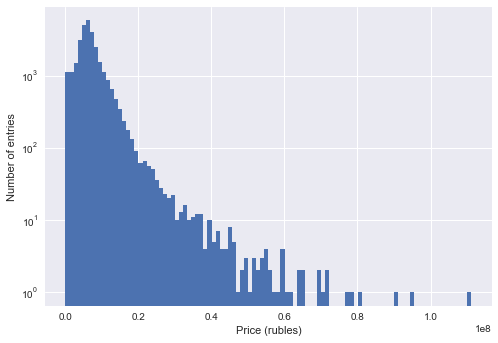

In [6]:
# histogram of prices
plt.figure()
plt.hist(train['price_doc'],bins=100)
plt.yscale('log')
plt.xlabel('Price (rubles)')
plt.ylabel('Number of entries')
plt.show()

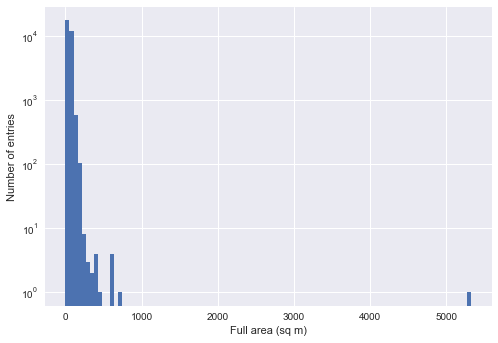

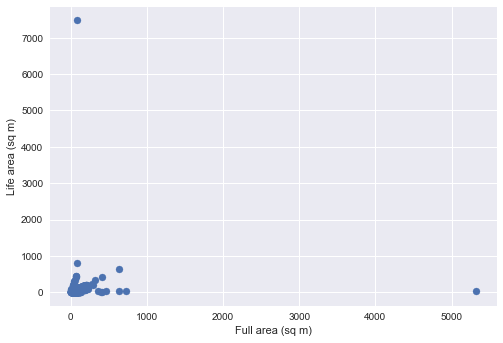

In [7]:
# area of appartment
plt.figure()
plt.hist(train['full_sq'],bins=100)
plt.yscale('log')
plt.xlabel('Full area (sq m)')
plt.ylabel('Number of entries')
plt.show()

plt.figure()
plt.scatter(train['full_sq'], train['life_sq'])
plt.xlabel('Full area (sq m)')
plt.ylabel('Life area (sq m)')
plt.show()

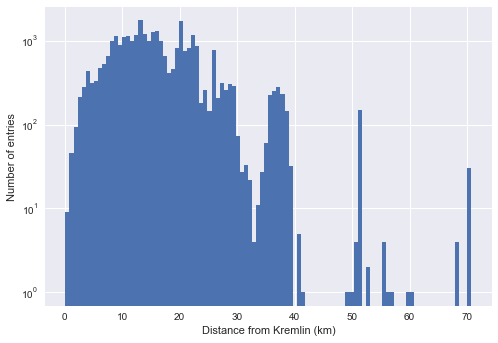

In [8]:
# distance from kremlin
plt.figure()
plt.hist(train['kremlin_km'],bins=100)
plt.yscale('log')
plt.xlabel('Distance from Kremlin (km)')
plt.ylabel('Number of entries')
plt.show()

### TODO
* Need to remove the outliers with full area or life area > 5000.
* Need to take care of entries with zero distance from Kremlin.

In [9]:
#train = train[(train['full_sq'] < 5000) & (train['life_sq'] < 5000)]

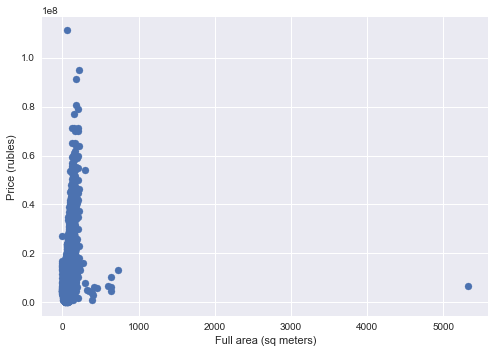

In [10]:
# price vs area
plt.figure()
plt.scatter(train['full_sq'], train['price_doc'])
plt.xlabel('Full area (sq meters)')
plt.ylabel('Price (rubles)')
plt.show()

Looks like there are three sub-classes in this plot.
    1.  Entries in the core distribution.
    2.  Entries with zero area.
    3.  Entries with large area and low price.

Let's try to remove #2.  I'm guessing #3 represents houses instead of apartments -- we can keep those in for now.

In [11]:
train.shape
train = train[(train['full_sq'] > 1)]

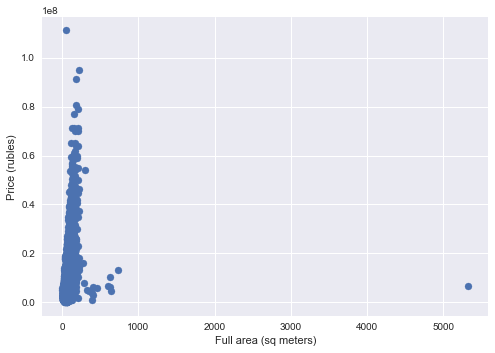

(30392, 291)

In [12]:
# price vs area (again)
plt.figure()
plt.scatter(train['full_sq'], train['price_doc'])
plt.xlabel('Full area (sq meters)')
plt.ylabel('Price (rubles)')
plt.show()

train.shape

That looks better, although it looks like we've lost about 20% of our training set...
This is probably something that we can't get around, since living area will be one of the most important features for pricing.

Let's move on for now.

In [13]:
# remove area Poselenie Klenovskoe -- does not appear in test set
train = train[train['sub_area'] != 'Poselenie Klenovskoe']
train.shape

(30391, 291)

In [14]:
# log transform of target price
# so that regression errors affect low and high prices equally
train.price_doc = np.log1p(train.price_doc)
y = train.price_doc

### Missing values
Need to take care of this...

# Features

Let us begin by finding the most important features for pricing.

In [15]:
print('Corelation with price:')
corr = train.corr()
corr.sort_values(['price_doc'], ascending=False, inplace=True)
print(corr.price_doc)

Corelation with price:
price_doc                     1.000000
num_room                      0.428866
sport_count_3000              0.275560
full_sq                       0.272171
sport_count_5000              0.270124
trc_count_5000                0.268791
sport_count_2000              0.264891
trc_count_3000                0.255981
office_sqm_5000               0.248999
cafe_count_5000_price_1000    0.246885
sport_count_1500              0.243624
sport_objects_raion           0.243302
cafe_count_3000_price_1000    0.241279
cafe_count_5000_price_1500    0.240214
cafe_count_5000               0.238371
cafe_count_5000_na_price      0.236489
cafe_count_2000_price_1000    0.235423
trc_sqm_5000                  0.233985
cafe_count_5000_price_500     0.233312
cafe_count_3000_price_1500    0.232472
cafe_count_5000_price_2500    0.230675
cafe_count_3000               0.230354
office_sqm_3000               0.228568
trc_count_2000                0.228480
cafe_count_1500_price_1000    0.227419
ch

Create year/month/day features using the timestamp:

In [16]:
train['time_year'] = train['timestamp']
train['time_month'] = train['timestamp']
train['time_day'] = train['timestamp']
train['time_year'] = train['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
train['time_month'] = train['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
train['time_day'] = train['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

test['time_year'] = test['timestamp']
test['time_month'] = test['timestamp']
test['time_day'] = test['timestamp']
test['time_year'] = test['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
test['time_month'] = test['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
test['time_day'] = test['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

Separate features into numerical and categorical:
#### TODO:
Check that numerical and categorical features are correct.

In [17]:
categorical_features = train.select_dtypes(include = ['object']).columns
categorical_features = categorical_features.drop('timestamp')
numerical_features = train.select_dtypes(exclude = ['object']).columns
numerical_features = numerical_features.drop('price_doc')
print('Numerical features : ' + str(len(numerical_features)))
print('Categorical features : ' + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

print('List of categorical features:')
print(categorical_features.values)

# do the same for the test set
categorical_featurest = test.select_dtypes(include = ['object']).columns
categorical_featurest = categorical_featurest.drop('timestamp')
numerical_featurest = test.select_dtypes(exclude = ['object']).columns
test_num = test[numerical_featurest]
test_cat = test[categorical_featurest]

Numerical features : 277
Categorical features : 15
List of categorical features:
['product_type' 'sub_area' 'culture_objects_top_25'
 'thermal_power_plant_raion' 'incineration_raion' 'oil_chemistry_raion'
 'radiation_raion' 'railroad_terminal_raion' 'big_market_raion'
 'nuclear_reactor_raion' 'detention_facility_raion' 'water_1line'
 'big_road1_1line' 'railroad_1line' 'ecology']


In [18]:
# for NaN's, fill with the median value
print("NAs for numerical features in train (before): " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("NAs for numerical features in train (after): " + str(train_num.isnull().values.sum()))

NAs for numerical features in train (before): 260662
NAs for numerical features in train (after): 0


In [19]:
print("NAs for categorical features in train: " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train: 0


In [20]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)

# test set
test_num = test_num.fillna(test_num.median())
test_cat = pd.get_dummies(test_cat)
print(test_cat.columns)

Index(['product_type_Investment', 'product_type_OwnerOccupier',
       'sub_area_Ajeroport', 'sub_area_Akademicheskoe',
       'sub_area_Alekseevskoe', 'sub_area_Altuf'evskoe', 'sub_area_Arbat',
       'sub_area_Babushkinskoe', 'sub_area_Basmannoe', 'sub_area_Begovoe',
       ...
       'water_1line_yes', 'big_road1_1line_no', 'big_road1_1line_yes',
       'railroad_1line_no', 'railroad_1line_yes', 'ecology_excellent',
       'ecology_good', 'ecology_no data', 'ecology_poor',
       'ecology_satisfactory'],
      dtype='object', length=176)


In [21]:
print('Number of numerical features in train: ', len(train_num.columns))
print('Number of categorical features in train: ', len(train_cat.columns))

Number of numerical features in train:  277
Number of categorical features in train:  176


# Modeling

Let's try a simple linear regression.

In [22]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("Number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

Number of features : 453
X_train : (21273, 453)
X_test : (9118, 453)
y_train : (21273,)
y_test : (9118,)


### TODO:
Standardize numerical features.

In [23]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

### Linear regression without regularization

/usr/local/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


RMSE on Training set : 1.03438221314
RMSE on Test set : 0.47548720853


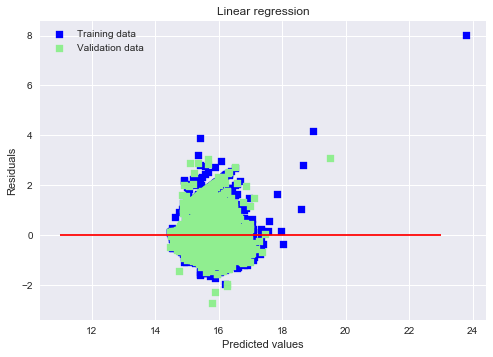

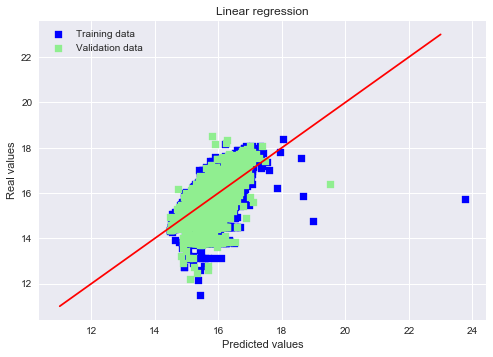

In [24]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11, xmax = 23, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11, 23], [11, 23], c = "red")
plt.show()

# Result: Linear regression

In [38]:
# Join categorical and numerical features
test = pd.concat([test_num, test_cat], axis = 1)

# compute the results
test['price_doc'] = lr.predict(test)

result = pd.DataFrame(np.exp(test['price_doc']),index=testid)
result.index.name = 'id'

print(result.head())

          price_doc
id                 
30474  5.902656e+06
30475  9.501890e+06
30476  6.510140e+06
30477  9.554370e+06
30478  6.467170e+06


In [39]:
# output to csv
outname = '../results/submission_linreg_' + datetime.now().strftime("%Y%m%d_%H%M") + '.csv'
result.to_csv(outname)

# Attempt at XGB
Inspired by https://www.kaggle.com/viveksrinivasan/eda-focus-on-missing-values-and-simple-xgb.

In [27]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:14.365	test-rmse:14.365
[50]	train-rmse:1.19989	test-rmse:1.20793
[100]	train-rmse:0.432799	test-rmse:0.477031
[150]	train-rmse:0.40179	test-rmse:0.466642
[200]	train-rmse:0.385249	test-rmse:0.466556


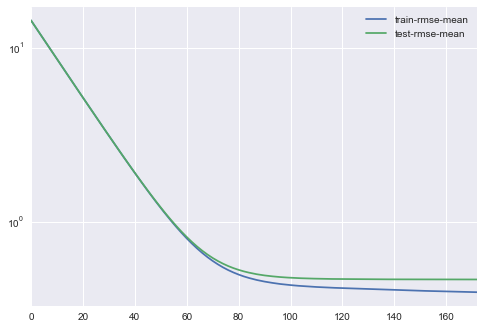

In [28]:
plt.figure()
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.yscale('log')
plt.show()

In [29]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

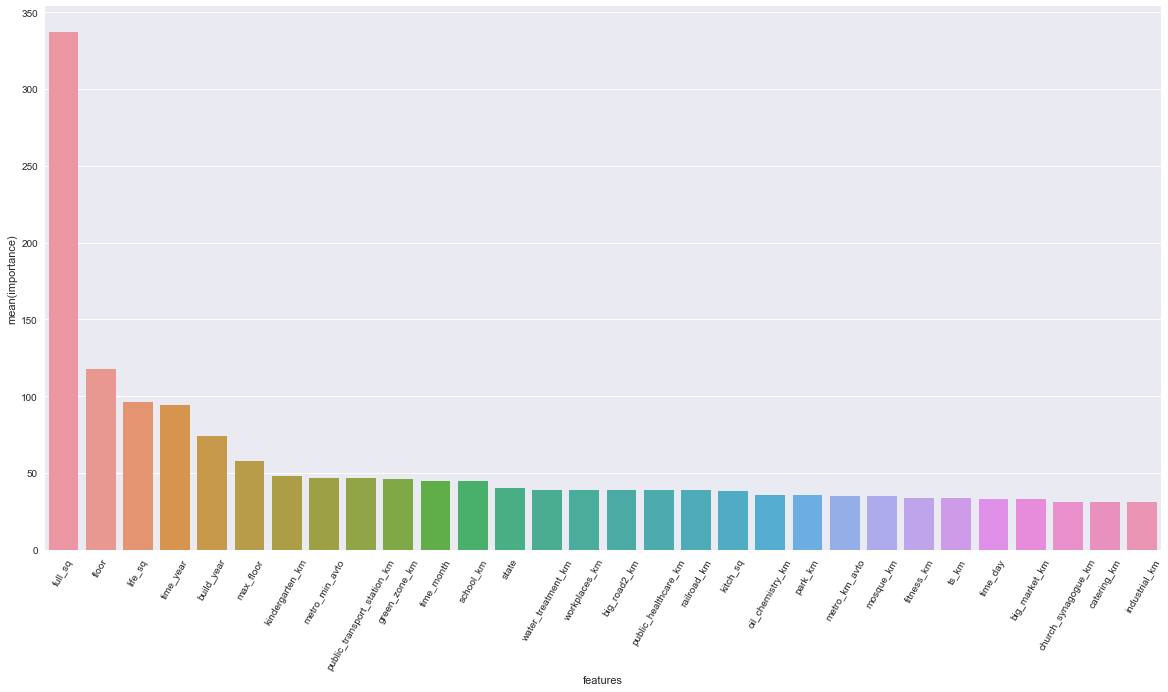

In [30]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
plt.figure()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sn.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")
plt.show()

# Results: XGB

In [36]:
# Join categorical and numerical features
testxgb = pd.concat([test_num, test_cat], axis = 1)

dtestxgb = xgb.DMatrix(testxgb)

# compute the results
testxgb['price_doc'] = model.predict(dtestxgb)

resultxgb = pd.DataFrame(np.exp(testxgb['price_doc']),index=testid)
resultxgb.index.name = 'id'
print(resultxgb.head())

       price_doc
id              
30474  5720438.5
30475  8370959.0
30476  5188791.5
30477  5376038.0
30478  5342602.0


In [37]:
# output to csv
outname = '../results/submission_xgb_' + datetime.now().strftime("%Y%m%d_%H%M") + '.csv'
resultxgb.to_csv(outname)